In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from dataclasses import dataclass

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import IPython.display as display
import matplotlib.pyplot as plt

from pathlib import Path

import random
import numpy as np
import matplotlib as mpl

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
@dataclass
class ConstParams:
    MODEL_NAME = "Base"

@dataclass
class HParams:
    IMAGE_HEIGHT = 300
    IMAGE_WIDTH = 300
    IMAGE_DEPTH = 3
    
    BUFFER_SIZE = 100
    BATCH_SIZE = 64
    
    SEED = 42
    RANDOM_STATE = 42
    
    NUM_EPOCH = 50
    LEARNING_RATE = 1e-5

@dataclass
class Paths:
    DATA_ROOT: Path = Path("./dataset")
    CHECKPOINT_DIR: Path = Path("./checkpoint/" + ConstParams.MODEL_NAME)
    BEST_CHECKPOINT_DIR: Path = Path("./checkpoint/" + ConstParams.MODEL_NAME + "/best")
    # save (img_path, label) pairs
    TRAIN_CSV_PATH: Path = Path("./csv/train.csv")
    VAL_CSV_PATH: Path = Path("./csv/val.csv")
    TEST_CSV_PATH: Path = Path("./csv/test.csv")

In [3]:
tf.random.set_seed(HParams.SEED)
np.random.seed(HParams.SEED)
random.seed(HParams.SEED)

if not Path("./dataset").exists():
    Path.mkdir(Path("./dataset"))

if not Path("./checkpoint").exists():
    Path.mkdir(Path("./checkpoint"))

if not Path("./csv").exists():
    Path.mkdir(Path("./csv"))

if not Paths.CHECKPOINT_DIR.exists():
    Path.mkdir(Paths.CHECKPOINT_DIR)

if not Paths.BEST_CHECKPOINT_DIR.exists():
    Path.mkdir(Paths.BEST_CHECKPOINT_DIR)

In [4]:
# print the subfolders.
print('classes:')
for item in Paths.DATA_ROOT.iterdir():
    print(item)
    
all_image_paths = list(Paths.DATA_ROOT.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=HParams.RANDOM_STATE)
# all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif', 'bmp', 'ini')]
all_image_paths = [path for path in all_image_paths if os.path.splitext(path)[1][1:] in ('jpg', 'JPG')]

image_count = len(all_image_paths)
print('\ntotal img num:', image_count)
# print(f'all image path = {all_image_paths}')

classes:
dataset\OWNER1_Door Damage
dataset\OWNER2_Panel dents or scratches
dataset\OWNER3_Panel aging, rust or breach
dataset\OWNER4_Placards removal
dataset\SHIPPER1_Floor stains, contamination or cracks
dataset\SHIPPER2_Panel or Sidewall protrusion
dataset\SHIPPER3_Cross member or forklift pocket overweight-deformation
dataset\SHIPPER4_Panel or Sidewalls dirts

total img num: 20000


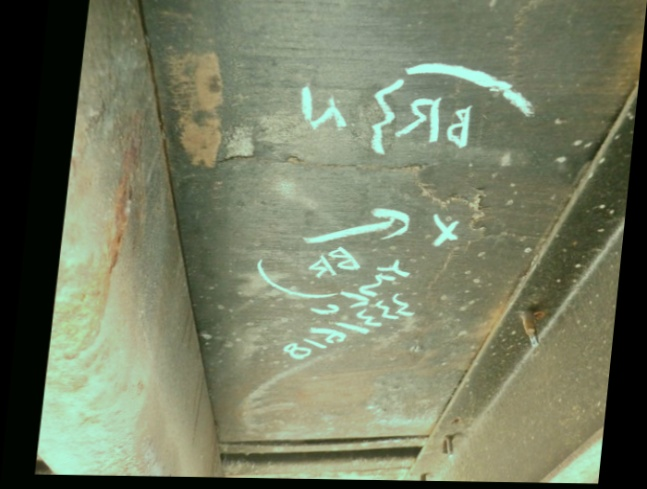

SHIPPER3_Cross member or forklift pocket overweight-deformation


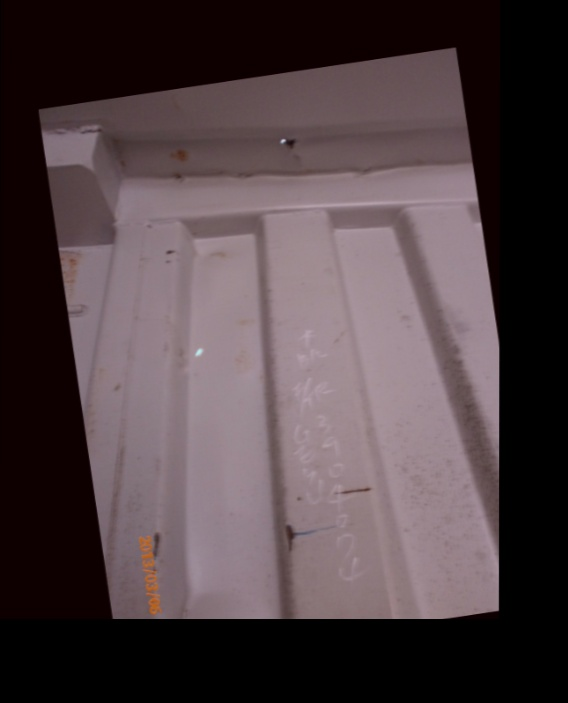

SHIPPER4_Panel or Sidewalls dirts


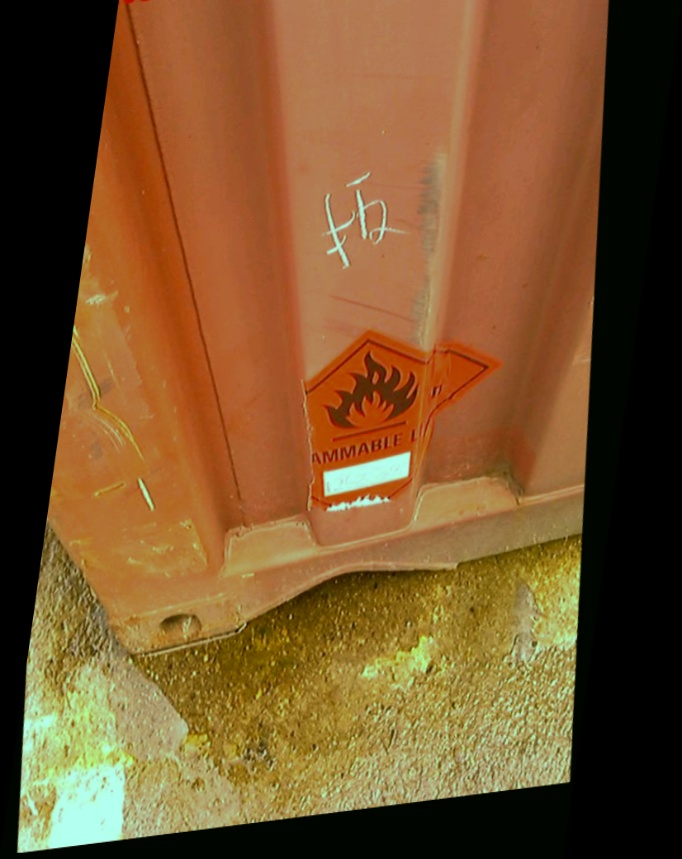

OWNER4_Placards removal


In [5]:
# random showing 3 iamges
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('\\')[-2])
    # print(image_path.split(os.path.sep)[-2])
    # print(image_path.split('/')[-2])

In [6]:
# get the label
label_names = sorted(item.name for item in Paths.DATA_ROOT.glob('*/') if item.is_dir())
# total label
n_classes = len(label_names)
print(label_names)

['OWNER1_Door Damage', 'OWNER2_Panel dents or scratches', 'OWNER3_Panel aging, rust or breach', 'OWNER4_Placards removal', 'SHIPPER1_Floor stains, contamination or cracks', 'SHIPPER2_Panel or Sidewall protrusion', 'SHIPPER3_Cross member or forklift pocket overweight-deformation', 'SHIPPER4_Panel or Sidewalls dirts']


In [7]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'OWNER1_Door Damage': 0, 'OWNER2_Panel dents or scratches': 1, 'OWNER3_Panel aging, rust or breach': 2, 'OWNER4_Placards removal': 3, 'SHIPPER1_Floor stains, contamination or cracks': 4, 'SHIPPER2_Panel or Sidewall protrusion': 5, 'SHIPPER3_Cross member or forklift pocket overweight-deformation': 6, 'SHIPPER4_Panel or Sidewalls dirts': 7}


In [8]:
# get the label data
all_image_label = [label_to_index[Path(path).parent.name] for path in all_image_paths]
print("First 10 label indices: ", all_image_label[:10])

First 10 label indices:  [7, 2, 3, 3, 1, 3, 2, 4, 7, 0]


In [9]:
# Create train:val:test datasets using an 80-10-10 split
img_path_train, img_path_val_and_test, label_train, label_val_and_test = train_test_split(all_image_paths, 
                                                                                          all_image_label,
                                                                                          test_size=0.2,
                                                                                          random_state=HParams.RANDOM_STATE)
img_path_val, img_path_test, label_val, label_test = train_test_split(img_path_val_and_test, 
                                                                      label_val_and_test, 
                                                                      test_size=0.5, 
                                                                      random_state=HParams.RANDOM_STATE)


print('training data: %d'%(len(img_path_train)))
print('validation data: %d'%(len(img_path_val)))
print('testing data: %d'%(len(img_path_test)))

training data: 16000
validation data: 2000
testing data: 2000


In [10]:
pairs_ready = False

if pairs_ready != True:
    # save (img_path, label) pairs
    with open(Paths.TRAIN_CSV_PATH, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['img_path', 'label'])
        for img_path, label in zip(img_path_train, label_train):
            writer.writerow([img_path, label])

    with open(Paths.VAL_CSV_PATH, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['img_path', 'label'])
        for img_path, label in zip(img_path_val, label_val):
            writer.writerow([img_path, label])

    with open(Paths.TEST_CSV_PATH, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['img_path', 'label'])
        for img_path, label in zip(img_path_test, label_test):
            writer.writerow([img_path, label])

In [11]:
class SimpleDataset(tf.data.Dataset):
    OUTPUT_SIGNATURE = (
        tf.TensorSpec(shape=(HParams.IMAGE_HEIGHT, HParams.IMAGE_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(SimpleDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        img_paths, label = open_file(filename)

        # Reading the file
        for sample_idx in range(len(img_paths)):
            img = read_file(img_paths[sample_idx])
            yield img, label[sample_idx]

    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )


In [12]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows['img_path'].tolist()
    label = rows['label'].tolist()
    return img_paths, label

def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=HParams.IMAGE_DEPTH)
    img = tf.image.resize(img, (HParams.IMAGE_HEIGHT, HParams.IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

def dataset_generator_fun_train(*args):
    return SimpleDataset(str(Paths.TRAIN_CSV_PATH), open_file, read_file)

def dataset_generator_fun_val(*args):
    return SimpleDataset(str(Paths.VAL_CSV_PATH), open_file, read_file)

def dataset_generator_fun_test(*args):
    return SimpleDataset(str(Paths.TEST_CSV_PATH), open_file, read_file)

In [13]:
# parse training data
@tf.function
def map_fun(image, label):
    distorted_image = tf.image.random_flip_left_right(image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=60)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)

    return distorted_image, label

# parse validation data
@tf.function
def map_fun_val(image, label):
    distorted_image = tf.image.per_image_standardization(image)

    return distorted_image, label

# parse testing data
@tf.function
def map_fun_test(image, label):
    distorted_image = tf.image.per_image_standardization(image)

    return distorted_image, label

In [14]:
dataset_train = tf.data.Dataset.range(1)\
                                .interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)\
                                .shuffle(HParams.BUFFER_SIZE, seed=HParams.SEED)\
                                .batch(HParams.BATCH_SIZE, drop_remainder=True)\
                                .map(map_fun_val, num_parallel_calls=tf.data.AUTOTUNE)\
                                .cache()\
                                .prefetch(tf.data.AUTOTUNE)

dataset_val = tf.data.Dataset.range(1)\
                                .interleave(dataset_generator_fun_val, num_parallel_calls=tf.data.AUTOTUNE)\
                                .batch(HParams.BATCH_SIZE, drop_remainder=True)\
                                .shuffle(HParams.BUFFER_SIZE, seed=HParams.SEED)\
                                .map(map_fun_val, num_parallel_calls=tf.data.AUTOTUNE)\
                                .cache()\
                                .prefetch(tf.data.AUTOTUNE)

dataset_test = tf.data.Dataset.range(1)\
                                .interleave(dataset_generator_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                .batch(HParams.BATCH_SIZE, drop_remainder=True)\
                                .map(map_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                .cache()\
                                .prefetch(tf.data.AUTOTUNE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 300, 3)


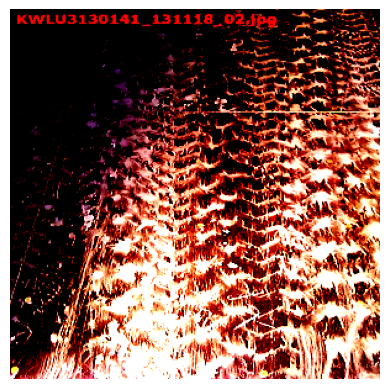

SHIPPER1_Floor stains, contamination or cracks


In [15]:
for img, label in dataset_train.take(1):
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [16]:
base_model = models.Sequential()

base_model.add(layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
base_model.add(layers.MaxPooling2D((2, 2)))
base_model.add(layers.LeakyReLU(alpha=0.1))
base_model.add(layers.BatchNormalization())

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(8, activation='relu'))
top_model.add(layers.BatchNormalization())
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

# 指定模型的輸入層
model_input = layers.Input(shape=(HParams.IMAGE_HEIGHT, HParams.IMAGE_WIDTH, HParams.IMAGE_DEPTH))

# 創建基底模型的輸出
base_model_output = base_model(model_input)

# 創建最終模型
model_output = top_model(base_model_output)
model = models.Model(inputs=model_input, outputs=model_output)

# model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 16)      512       
_________________________________________________________________
sequential_1 (Sequential)    (None, 8)                 2880112   
Total params: 2,880,624
Trainable params: 2,880,576
Non-trainable params: 48
_________________________________________________________________


In [18]:
# define loss and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(HParams.LEARNING_RATE)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [19]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = model(image, training=True)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
#     print("Label shape:", label.shape)
#     print("Predictions shape:", predictions.shape)

    train_loss(loss)
    train_accuracy(label, predictions)
    
@tf.function
def val_step(image, label):
    predictions = model(image, training=False)
    loss = loss_object(label, predictions)

    val_loss(loss)
    val_accuracy(label, predictions)
    
@tf.function
def test_step(image, label):
    predictions = model(image, training=False)
    loss = loss_object(label, predictions)

    return loss, label, predictions

In [20]:
checkpoint = tf.train.Checkpoint(model=model)
ckpt_manager = tf.train.CheckpointManager(
    checkpoint,  Paths.CHECKPOINT_DIR, max_to_keep=3
)
best_manager = tf.train.CheckpointManager(
    checkpoint, Paths.BEST_CHECKPOINT_DIR, max_to_keep=1
)

In [21]:
train_loss_list = []
val_loss_list = []

def epoch_loop(dataset_train, dataset_test, EPOCHS):
    best_val_acc = 0.
    for epoch in range(EPOCHS):
        print("=" * 10 + f" Epoch {epoch + 1}/{EPOCHS} " + "=" * 10)
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        val_loss.reset_states()
        val_accuracy.reset_states()

        tf.print("training:")
        for image, label in tqdm(dataset_train, total=math.floor(len(img_path_train)/HParams.BATCH_SIZE)):
            train_step(image, label)

        tf.print("validating:")
        for image, label in tqdm(dataset_val, total=math.floor(len(img_path_val)/HParams.BATCH_SIZE)):
            val_step(image, label)
            
        train_loss_list.append(train_loss.result().numpy())
        val_loss_list.append(val_loss.result().numpy())
     
        template = 'Epoch {:0}, Training loss: {:.4f}, Training accuracy: {:.4f}, Validation loss: {:.4f}, Validation Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               val_loss.result(),
                               val_accuracy.result()*100))
        
        # Save weight after each epoch
        ckpt_manager.save()
        
        # Save best weight
        if val_accuracy.result() > best_val_acc:
            best_val_acc = val_accuracy.result()
            best_manager.save()
            print(f"Best model saved at {best_manager.latest_checkpoint}.")

In [22]:
epoch_loop(dataset_train, dataset_val, EPOCHS= HParams.NUM_EPOCH)

========== Epoch 1/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [02:24<00:00,  1.73it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:21<00:00,  1.43it/s]

Epoch 1, Training loss: 2.1231, Training accuracy: 23.1187, Validation loss: 1.8296, Validation Accuracy: 30.1411


Best model saved at checkpoint\Base\best\ckpt-2.
========== Epoch 2/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:05<00:00,  3.79it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.61it/s]


Epoch 2, Training loss: 1.9679, Training accuracy: 26.9437, Validation loss: 1.7469, Validation Accuracy: 35.0806
Best model saved at checkpoint\Base\best\ckpt-4.
========== Epoch 3/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:10<00:00, 22.97it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 60.70it/s]

Epoch 3, Training loss: 1.9234, Training accuracy: 28.4438, Validation loss: 1.7260, Validation Accuracy: 35.7359


Best model saved at checkpoint\Base\best\ckpt-6.
========== Epoch 4/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.66it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.72it/s]

Epoch 4, Training loss: 1.8874, Training accuracy: 28.9875, Validation loss: 1.7271, Validation Accuracy: 35.9375


Best model saved at checkpoint\Base\best\ckpt-8.
========== Epoch 5/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.97it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 63.24it/s]

Epoch 5, Training loss: 1.8530, Training accuracy: 29.8187, Validation loss: 1.6926, Validation Accuracy: 36.6431


Best model saved at checkpoint\Base\best\ckpt-10.
========== Epoch 6/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.93it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.00it/s]

Epoch 6, Training loss: 1.8413, Training accuracy: 30.2625, Validation loss: 1.6999, Validation Accuracy: 35.1311


========== Epoch 7/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 37.02it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.59it/s]

Epoch 7, Training loss: 1.7886, Training accuracy: 31.7688, Validation loss: 1.6907, Validation Accuracy: 37.9032


Best model saved at checkpoint\Base\best\ckpt-13.
========== Epoch 8/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.97it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.16it/s]

Epoch 8, Training loss: 1.7686, Training accuracy: 32.1250, Validation loss: 1.6629, Validation Accuracy: 37.1472


========== Epoch 9/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.95it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.70it/s]

Epoch 9, Training loss: 1.7475, Training accuracy: 32.6750, Validation loss: 1.6665, Validation Accuracy: 37.1976


========== Epoch 10/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.84it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.09it/s]

Epoch 10, Training loss: 1.7126, Training accuracy: 34.4688, Validation loss: 1.6769, Validation Accuracy: 36.6936
========== Epoch 11/50 ==========
training:



100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.91it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.46it/s]


Epoch 11, Training loss: 1.7096, Training accuracy: 33.8000, Validation loss: 1.6703, Validation Accuracy: 38.2056
Best model saved at checkpoint\Base\best\ckpt-18.
========== Epoch 12/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.85it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.77it/s]

Epoch 12, Training loss: 1.6667, Training accuracy: 35.8687, Validation loss: 1.6692, Validation Accuracy: 37.5504


========== Epoch 13/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.92it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.78it/s]


Epoch 13, Training loss: 1.6408, Training accuracy: 36.1937, Validation loss: 1.6757, Validation Accuracy: 38.3569
Best model saved at checkpoint\Base\best\ckpt-21.
========== Epoch 14/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.86it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 63.28it/s]

Epoch 14, Training loss: 1.6066, Training accuracy: 38.2562, Validation loss: 1.6730, Validation Accuracy: 38.0544


========== Epoch 15/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.99it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.15it/s]

Epoch 15, Training loss: 1.6004, Training accuracy: 37.8125, Validation loss: 1.6724, Validation Accuracy: 38.4073


Best model saved at checkpoint\Base\best\ckpt-24.
========== Epoch 16/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.96it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.21it/s]

Epoch 16, Training loss: 1.5763, Training accuracy: 38.5062, Validation loss: 1.6880, Validation Accuracy: 36.2399
========== Epoch 17/50 ==========
training:



100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.66it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.30it/s]


Epoch 17, Training loss: 1.5462, Training accuracy: 40.3937, Validation loss: 1.6799, Validation Accuracy: 36.3407
========== Epoch 18/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.83it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.29it/s]

Epoch 18, Training loss: 1.5243, Training accuracy: 41.0750, Validation loss: 1.6576, Validation Accuracy: 37.8024
========== Epoch 19/50 ==========
training:



100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.41it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.38it/s]


Epoch 19, Training loss: 1.4988, Training accuracy: 42.1562, Validation loss: 1.6802, Validation Accuracy: 36.3911
========== Epoch 20/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.45it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 63.20it/s]

Epoch 20, Training loss: 1.4793, Training accuracy: 42.7125, Validation loss: 1.6640, Validation Accuracy: 37.6008


========== Epoch 21/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 37.01it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.43it/s]

Epoch 21, Training loss: 1.4587, Training accuracy: 43.9062, Validation loss: 1.6749, Validation Accuracy: 36.9960


========== Epoch 22/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.92it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.79it/s]


Epoch 22, Training loss: 1.4357, Training accuracy: 44.9500, Validation loss: 1.6688, Validation Accuracy: 37.3992
========== Epoch 23/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.99it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.56it/s]

Epoch 23, Training loss: 1.4215, Training accuracy: 45.6313, Validation loss: 1.6803, Validation Accuracy: 36.9456


========== Epoch 24/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.88it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.38it/s]

Epoch 24, Training loss: 1.3999, Training accuracy: 46.5500, Validation loss: 1.6756, Validation Accuracy: 36.2399
========== Epoch 25/50 ==========
training:



100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 37.02it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.72it/s]


Epoch 25, Training loss: 1.3812, Training accuracy: 47.2625, Validation loss: 1.6887, Validation Accuracy: 37.7016
========== Epoch 26/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.93it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.34it/s]

Epoch 26, Training loss: 1.3598, Training accuracy: 48.5687, Validation loss: 1.6701, Validation Accuracy: 37.2984
========== Epoch 27/50 ==========
training:



100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.92it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.09it/s]


Epoch 27, Training loss: 1.3463, Training accuracy: 48.6125, Validation loss: 1.6889, Validation Accuracy: 35.5847
========== Epoch 28/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 37.01it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.62it/s]

Epoch 28, Training loss: 1.3295, Training accuracy: 50.2000, Validation loss: 1.6752, Validation Accuracy: 37.0968


========== Epoch 29/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.97it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.61it/s]


Epoch 29, Training loss: 1.3108, Training accuracy: 50.7563, Validation loss: 1.6919, Validation Accuracy: 37.3488
========== Epoch 30/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.89it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.98it/s]


Epoch 30, Training loss: 1.2832, Training accuracy: 52.2000, Validation loss: 1.6749, Validation Accuracy: 37.0464
========== Epoch 31/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.91it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.01it/s]

Epoch 31, Training loss: 1.2599, Training accuracy: 53.5187, Validation loss: 1.6912, Validation Accuracy: 36.7439
========== Epoch 32/50 ==========
training:



100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.90it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.11it/s]


Epoch 32, Training loss: 1.2620, Training accuracy: 52.8813, Validation loss: 1.6731, Validation Accuracy: 36.8952
========== Epoch 33/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.89it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.81it/s]


Epoch 33, Training loss: 1.2470, Training accuracy: 53.8625, Validation loss: 1.6789, Validation Accuracy: 36.7439
========== Epoch 34/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.98it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.11it/s]

Epoch 34, Training loss: 1.2302, Training accuracy: 54.8563, Validation loss: 1.6816, Validation Accuracy: 37.3992


========== Epoch 35/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 37.00it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 60.69it/s]

Epoch 35, Training loss: 1.2218, Training accuracy: 54.9625, Validation loss: 1.6754, Validation Accuracy: 36.7439
========== Epoch 36/50 ==========
training:



100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.99it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 60.91it/s]


Epoch 36, Training loss: 1.2054, Training accuracy: 55.9313, Validation loss: 1.6826, Validation Accuracy: 36.9456
========== Epoch 37/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.99it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 59.46it/s]

Epoch 37, Training loss: 1.1916, Training accuracy: 55.9750, Validation loss: 1.6823, Validation Accuracy: 37.2984
========== Epoch 38/50 ==========
training:



100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 37.04it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 60.70it/s]

Epoch 38, Training loss: 1.1723, Training accuracy: 57.3313, Validation loss: 1.6819, Validation Accuracy: 37.6008
========== Epoch 39/50 ==========
training:



100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 37.01it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.87it/s]

Epoch 39, Training loss: 1.1607, Training accuracy: 57.9000, Validation loss: 1.6862, Validation Accuracy: 36.0383


========== Epoch 40/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.97it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.41it/s]

Epoch 40, Training loss: 1.1526, Training accuracy: 58.4313, Validation loss: 1.6854, Validation Accuracy: 36.2903


========== Epoch 41/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.97it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.89it/s]

Epoch 41, Training loss: 1.1385, Training accuracy: 58.8000, Validation loss: 1.6778, Validation Accuracy: 36.9960


========== Epoch 42/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.87it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.20it/s]

Epoch 42, Training loss: 1.1099, Training accuracy: 60.4625, Validation loss: 1.7005, Validation Accuracy: 35.8367


========== Epoch 43/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.81it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.81it/s]


Epoch 43, Training loss: 1.1246, Training accuracy: 59.7250, Validation loss: 1.6871, Validation Accuracy: 37.1976
========== Epoch 44/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.94it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 63.17it/s]


Epoch 44, Training loss: 1.1056, Training accuracy: 60.2125, Validation loss: 1.6936, Validation Accuracy: 36.4919
========== Epoch 45/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.23it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.87it/s]

Epoch 45, Training loss: 1.0865, Training accuracy: 61.9500, Validation loss: 1.7063, Validation Accuracy: 36.6431


========== Epoch 46/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.70it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.50it/s]

Epoch 46, Training loss: 1.0871, Training accuracy: 61.5250, Validation loss: 1.7080, Validation Accuracy: 36.5927
========== Epoch 47/50 ==========
training:



100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.78it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.00it/s]


Epoch 47, Training loss: 1.0670, Training accuracy: 62.6125, Validation loss: 1.7191, Validation Accuracy: 37.7520
========== Epoch 48/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.88it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.37it/s]

Epoch 48, Training loss: 1.0520, Training accuracy: 63.1063, Validation loss: 1.7116, Validation Accuracy: 36.6936
========== Epoch 49/50 ==========
training:



100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.70it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.10it/s]

Epoch 49, Training loss: 1.0449, Training accuracy: 63.1688, Validation loss: 1.6996, Validation Accuracy: 38.7601


Best model saved at checkpoint\Base\best\ckpt-59.
========== Epoch 50/50 ==========
training:


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 36.86it/s]

validating:



100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 62.02it/s]

Epoch 50, Training loss: 1.0320, Training accuracy: 63.8438, Validation loss: 1.7112, Validation Accuracy: 37.9032


In [23]:
true_label = []
predicted_label = []

def test_loop(dataset_test):
    print(f"Model restored from {tf.train.latest_checkpoint(Paths.BEST_CHECKPOINT_DIR)}.")
    checkpoint = tf.train.Checkpoint(model=model)
    checkpoint.restore(tf.train.latest_checkpoint(Paths.BEST_CHECKPOINT_DIR))
    
    for image, label in tqdm(dataset_test, total=math.floor(len(img_path_test)/HParams.BATCH_SIZE)):
        loss, labels, predictions = test_step(image, label)
        
        true_label.extend(labels.numpy())
        predicted_label.extend(tf.argmax(predictions, axis=1).numpy())
        
        test_loss(loss)
        test_accuracy(labels, predictions)

    template = 'Test loss: {:.4f}, Test accuracy: {:.4f}'
    tf.print(template.format(test_loss.result(), test_accuracy.result()*100))

test_loop(dataset_test)

Model restored from checkpoint\Base\best\ckpt-59.


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:19<00:00,  1.57it/s]

Test loss: 1.6767, Test accuracy: 38.8609


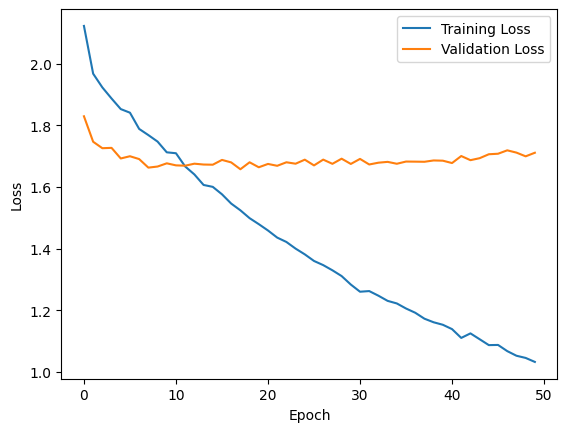

In [24]:
# Plot training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

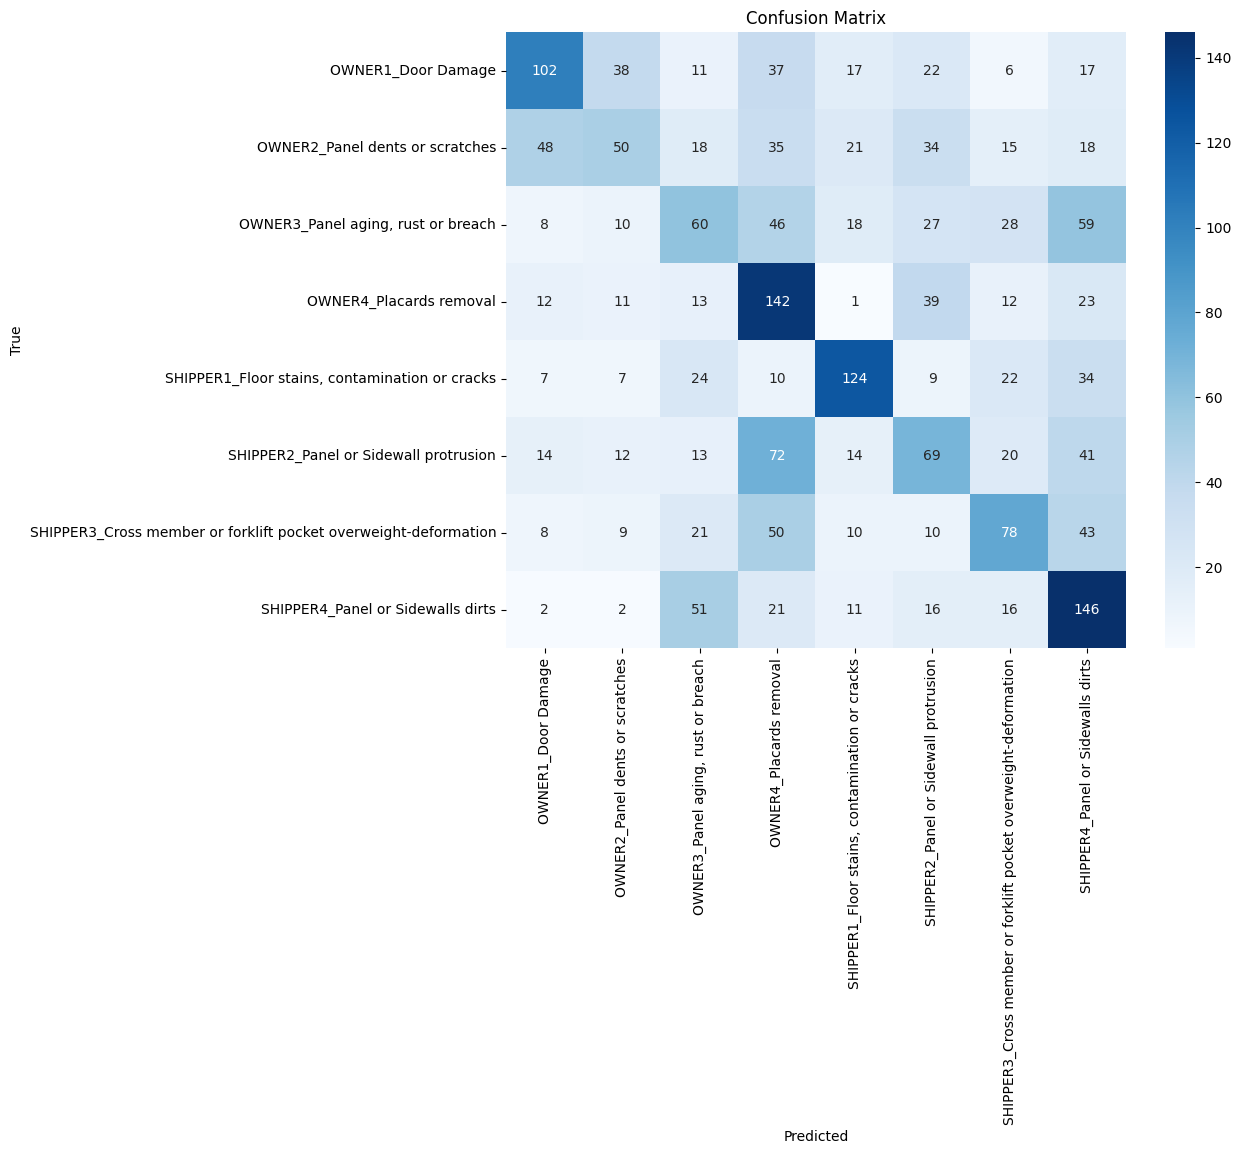

In [25]:
cm = confusion_matrix(true_label, predicted_label)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()